In [92]:
import os
import json

import numpy as np

import matplotlib
import matplotlib.pyplot as plt


import detectron2
import detectron2.data.transforms as T

import labelme
from labelme import LabelFile
from labelme import utils
import imgviz

In [197]:
def json_to_dict(directory, img_height, img_width):
    # Load only .json files in the directory
    path = directory
    valid_filetype = [".json"]
    for file in os.listdir(path):
        ext = os.path.splitext(file)[1] # find he extension of the file
        if ext.lower() not in valid_filetype:
            continue
    return dataset_dictionary  # list[dict]

In [195]:
def json_to_arrs(json_file):
    """
    Load image and polygon mask from a jsonfile
    Output a list of images in np arrays and a list of polygon masks in np array
    """
    imgs = []
    polygon_list = []
    # Load data from json
    data = json.load(open(json_file))
    # Append images to a list of nd arrays
    img_data = data.get("imageData")
    img = labelme.utils.img_b64_to_arr(img_data) # load image to np array
    imgs.append(img)
    # Append mask to a list of polygons
    poly = data.get("shapes")
    poly_for_single_img = []
    for polyitem in poly:
        polygon = np.array(polyitem.get("points"))
        polygon = np.reshape(polygon,(len(polygon),2))
        poly_for_single_img.append(polygon)
    polygon_list.append(poly_for_single_img)
    return imgs, polygon_list

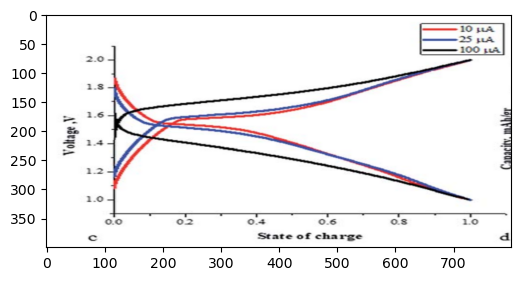

In [94]:
# Rescale the images and masks
# Outputs a list of rescaled images and a list of rescales masks in nparray
matplotlib.rcParams['figure.dpi'] = 100
height = 400 
width = 800
#shortest_edge_len = 300
max_len = 800
new_imgs = []
new_masks = []
encoded_imgs = []
# Resize image and mask to have uniform shrtest lengths
# shortest_edge = T.ResizeShortestEdge(shortest_edge_len, max_len)

for i,img in enumerate(imgs):
    # Scale image to desired width and height
    scale = T.ScaleTransform(np.shape(img)[0],np.shape(img)[1], height, width)
    new_imgs.append(scale.apply_image(img, "bilinear"))
#   encoded_img = utils.img_arr_to_b64(new_imgs[0])
    scaled_poly = scale.apply_polygons(polygon_list[i])
    new_masks.append(scaled_poly)
    #shortest_edge_transform = shortest_edge.get_transform(img)
    #type(shortest_edge_transform)
    #new_imgs.append(shortest_edge_transform.apply_image(img))
    #new_masks.append(shortest_edge_transform.apply_polygons(polygon_list[i]))

plt.imshow(new_imgs[0])
plt.show()

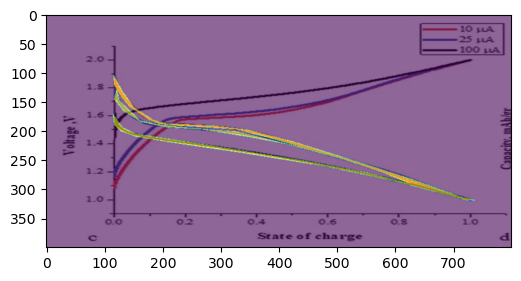

In [116]:
# Check Scaled image and mask
img_num = 0
for index,mask in enumerate(polygon_list[img_num]):
    data["shapes"][index]["points"] = new_masks[img_num][index]

img = new_imgs[0]

label_name_to_value = {"_background_": 0}
for shape in sorted(data["shapes"], key=lambda x: x["label"]):
    label_name = shape["label"]
    if label_name in label_name_to_value:
        label_value = label_name_to_value[label_name]
    else:
        label_value = len(label_name_to_value)
        label_name_to_value[label_name] = label_value
        
lbl, _ = utils.shapes_to_label(img.shape, data["shapes"], label_name_to_value)


label_names = [None] * (max(label_name_to_value.values()) + 1)
for name, value in label_name_to_value.items():
    label_names[value] = name

lbl_viz = imgviz.label2rgb(
    label=lbl, img=imgviz.asgray(img), label_names=label_names, loc="rb"
)

plt.imshow(img,alpha=1)
plt.imshow(lbl, alpha=0.6)
#type(lbl_viz)
#plt.imshow(new_imgs[0])
#plt.show()

In [182]:
# Reshaped polygon list to Detectron2 acceptable format
def polygon_arr_to_list(polygon_list):
    """
    This funtion converts the polygon_list output from function to 
    Detectron2 accpeted format and found the bounding boxes
    """
    reshaped_polygon_list = []
    bb_box_list =[]
    for img, polygons in enumerate(polygon_list):
        #print(polygons)
        reshaped_polys = []
        bb_boxes = []
        for ind, polygon in enumerate(polygons):
            #print(polygon)
            reshaped_poly = polygon.reshape(1,polygon.shape[0]*polygon.shape[1]).tolist()[0]            
            # [min_x, min_y, max_x, max_y]
            bb_box = [np.min(reshaped_poly[0::2]),
                      np.min(reshaped_poly[1::2]),
                      np.max(reshaped_poly[0::2]),
                      np.max(reshaped_poly[1::2])]
            reshaped_polys.append(reshaped_poly)
            bb_boxes.append(bb_box)
        reshaped_polygon_list.append(reshaped_polys)
        bb_box_list.append(bb_boxes)
    return reshaped_polygon_list, bb_box_list

In [193]:
poly,bb = polygon_arr_to_list(polygon_list)
#polygon_arr_to_list(polygon_list)[img][mask]
#print(bb)
#print(poly)

In [105]:
# Update json files and save as in new directory
#def detectron2_dict():
    """
    Save all information into detectron2 dictionary
    """
#    return dictionary # list[dict]
    
img_num = 0
for file in os.listdir(path):
    ext = os.path.splitext(file)[1] # find he extension of the file
    if ext.lower() not in valid_filetype:
        continue
    new_filename = file+"_scaled" # create new json filename
    record = {}
    record["file_name"] = new_filename
    record["image_id"] = img_num
    record["height"] = height 
    record["width"] = width

    # Each dict corresponds to annotations of one instance in this image, and may contain the following keys:
    objs = [] # list of dict [{instance1},{instance2},{instance3}}]] 
    anno = {}
    for ind,mask in enumerate(reshaped_polygon_list):
        anno = {}
        # Each list[float] is one simple polygon in the format of [x1, y1, ..., xn, yn].
        # The Xs and Ys are absolute coordinates in unit of pixels.
        anno["segmentation"] = [reshaped_polygon_list[img][ind]] # list[list[float]]
        anno["bbox"]: [np.min(px), np.min(py), np.max(px), np.max(py)] #(bbox)
        anno["bbox_mode"]: BoxMode.XYXY_ABS #(bbox_mode)
        anno["category_id"]: 0 # category label: Only one category
        objs.append(anno)    
    record["annotations"] = objs # list of dict [{instance1},{instance2},{instance3}}]]
    img_num = img_num+1


In [ ]:
 json_file = os.path.join(img_dir, "DischargeCurve_annotatedexample.json") #(img_dir) (via_export_json.json) (jason_file)
    with open(json_file) as f: #(jason_file)
        imgs_anns = json.load(f) #(imgs_anns)
    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()): # (idx)* (v)
        record = {}
        
        filename = os.path.join(img_dir, v["filename"]) #(filename) (img_dir) (v)
        height, width = cv2.imread(filename).shape[:2] #(filename)
        
        record["file_name"] = filename #(filename)
        record["image_id"] = idx #(idx)*
        record["height"] = height 
        record["width"] = width
        # list of dict
        # Each dict corresponds to annotations of one instance in this image, and may contain the following keys:

        objs = [] # list of dict
        # list [list[]]
        # Each list[float] is one simple polygon in the format of [x1, y1, ..., xn, yn]. 
        # The Xs and Ys are absolute coordinates in unit of pixels.
        anno = {}
        anno["segmentation"] = reshaped_polygon_list[img]
        for anno in annos:
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)], #(bbox)
                "bbox_mode": BoxMode.XYXY_ABS, #(bbox_mode)
                "segmentation": [poly],
                "category_id": 0, # category label: Only one category
                "iscrowd": 0
                }
            objs.append(obj)
            print(objs)
        record["annotations"] = objs

        dataset_dicts.append(record)

In [97]:
"""
Mango example
"""
def get_dicts(img_dir): #(img_dir)
    json_file = os.path.join(img_dir, "DischargeCurve_annotatedexample.json") #(img_dir) (via_export_json.json) (jason_file)
    with open(json_file) as f: #(jason_file)
        imgs_anns = json.load(f) #(imgs_anns)
    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()): # (idx)* (v)
        record = {}
        
        filename = os.path.join(img_dir, v["filename"]) #(filename) (img_dir) (v)
        height, width = cv2.imread(filename).shape[:2] #(filename)
        
        record["file_name"] = filename #(filename)
        record["image_id"] = idx #(idx)*
        record["height"] = height 
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for anno in annos:
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)], #(bbox)
                "bbox_mode": BoxMode.XYXY_ABS, #(bbox_mode)
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
                }
            objs.append(obj)
            print(objs)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

"""
As I only have 1 class (mango), the category_id is set to 0

iscrowd is 0 because our mango detection is a single object segmentation



"""

'\nAs I only have 1 class (mango), the category_id is set to 0\n\niscrowd is 0 because our mango detection is a single object segmentation\n\n\n\n'

In [103]:
"""
Type Error 
"""
# Update json files and save as in new directory
img_num = 0
for file in os.listdir(path):
    ext = os.path.splitext(file)[1] # find he extension of the file
    if ext.lower() not in valid_filetype:
        continue
    data = json.load(open(file))
    new_filename = file+"_scaled" # create new json filename
    # Update polygon masks information while keeping the keys
    for index,mask in enumerate(polygon_list[img_num]):
        data["shapes"][index]["points"] = new_masks[img_num][index]
    # Update other dictionary information
    data["imageHeight"] = height
    data["imageWidth"] = width
    data["imagePath"] = path+"./Scaled"+new_filename
    data["imageData"] = utils.img_arr_to_b64(imgs[img_num])
    # Save to new json file
    with open(new_filename, 'w') as json_file:
        print("hi")
        json.dump(data, json_file)
    img_num = img_num+1


hi


TypeError: Object of type ndarray is not JSON serializable

In [ ]:
"""
    
    # Update polygon masks information while keeping the keys
    for index,mask in enumerate(polygon_list[img_num]):
        data["shapes"][index]["points"] = polygon_list[img_num][index]

"""

In [ ]:
utils.img_arr_to_b64(imgs[img_num])

In [ ]:
    lbf = LabelFile()
    lbf.save(
                   filename=new_filename,
                   shapes=data.get("shapes"),
                   imagePath=path+"./Scaled"+new_filename,
                   imageHeight=height,
                   imageWidth=width,
                   imageData=None)


In [ ]:
# Crop and Pad image and mask
# Use Centerpadtofixedsize() to pad image to fixed size
# Get padded pixels imgaug and move polygon masks to corresponding positions

https://imgaug.readthedocs.io/en/latest/source/api_augmenters_size.html?highlight=padto#imgaug.augmenters.size.CenterPadToFixedSize